# INTRO

In this notebook I use several CNN - architectures to recognize Blood cell desises.


**Context**:
The diagnosis of blood-based diseases often involves identifying and characterizing patient blood samples. Automated methods to detect and classify blood cell subtypes have important medical applications. The dataset and additional information can be found here [Kaggle Blood Cell Images](https://www.kaggle.com/paultimothymooney/blood-cells)

**Architectures**: 
- Self created architecture containing ResNet blocks, Inception blocks, One-to-One convolutions and several other layers
- ResNet50 using pretrained weights only to the first half of the network
- Inception using pretrained weights only to the first 2/3 of the network



# Imports and Notebook Settings

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [1]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

Gen RAM Free: 12.7 GB  | Proc size: 153.2 MB
GPU RAM Free: 15079MB | Used: 0MB | Util   0% | Total 15079MB


In [6]:
import torch
torch.cuda.is_available()

True

In [3]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

TensorFlow 2.x selected.
2.1.0


In [0]:
# Basic Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import keras

# Imports for the Model
from tensorflow.keras.layers import Input, Add, Activation, Conv2D, ZeroPadding2D, Dense, Flatten, Dropout, GlobalMaxPooling2D, MaxPooling2D, BatchNormalization, concatenate
from tensorflow.keras.applications.resnet50 import ResNet50 as PretrainedModel, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Preprocessing Images
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Saving and Loading
from tensorflow.keras.models import load_model

# Folder operations
from glob import glob
import sys, os

# Others
from sklearn.utils import shuffle

# Notebook Settings
pd.set_option('display.max_columns', None, 'display.max_rows', 100)

# Dataset Preperation

In [9]:
# Unzipping is faster than to upload unzipped to drive
from zipfile import ZipFile
file_name = '/content/drive/My Drive/Colab Notebooks/Blood_Cells/images.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [5]:
# Getting to the folder we need
cd /content/images

/content/images


In [6]:
# Checking whats in there:
!ls

best_model.h5  TEST  TEST_SIMPLE  TRAIN


In [7]:
print('TRAIN')
!ls TRAIN
print()
print('TEST')
!ls TEST
print()
print('TEST_SIMPLE')
!ls TEST_SIMPLE

TRAIN
EOSINOPHIL  LYMPHOCYTE	MONOCYTE  NEUTROPHIL

TEST
EOSINOPHIL  LYMPHOCYTE	MONOCYTE  NEUTROPHIL

TEST_SIMPLE
EOSINOPHIL  LYMPHOCYTE	MONOCYTE  NEUTROPHIL


In [0]:
# Holding the paths:
train_path = 'TRAIN'
valid_path = 'TEST'
test_path = 'TEST_SIMPLE'

# useful for getting number of files
image_files = glob(train_path + '/*/*.jp*g')
valid_image_files = glob(valid_path + '/*/*.jp*g')
test_images = glob(test_path + '/*/*.jp*g')

## Basic EDA

In [9]:
# Number of classes
# useful for getting number of classes
folders = glob(train_path + '/*')
K = len(folders)
print('Number of classes: {}'.format(K))

Number of classes: 4


In [10]:
# Number of images in the different datasets
print('# Training Images {}'.format(len(image_files)))
print('# Validation Images {}'.format(len(valid_image_files)))
print('# Testing Images {}'.format(len(test_images)))

# Training Images 9957
# Validation Images 2487
# Testing Images 71


Distribution of the train set classes


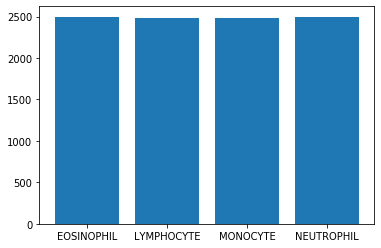

In [11]:
# Checking the Distribution of the train classes
print('Distribution of the train set classes')
tm1 = glob(train_path + '/EOSINOPHIL' +  '/*.jp*g')
tm2 = glob(train_path + '/LYMPHOCYTE' +  '/*.jp*g')
tm3 = glob(train_path + '/MONOCYTE' +  '/*.jp*g')
tm4 = glob(train_path + '/NEUTROPHIL' +  '/*.jp*g')

dict_train = {'EOSINOPHIL': len(tm1), 'LYMPHOCYTE': len(tm2), 'MONOCYTE': len(tm3), 'NEUTROPHIL': len(tm4)}
plt.bar(dict_train.keys(), dict_train.values())
plt.show()

Distribution of the train set classes


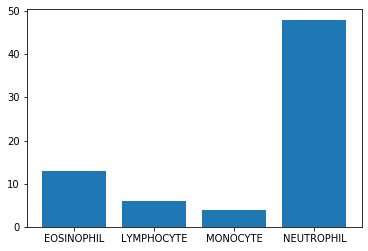

In [12]:
# Checking the Distribution of the test classes
print('Distribution of the train set classes')
tm1 = glob(test_path + '/EOSINOPHIL' +  '/*.jp*g')
tm2 = glob(test_path + '/LYMPHOCYTE' +  '/*.jp*g')
tm3 = glob(test_path + '/MONOCYTE' +  '/*.jp*g')
tm4 = glob(test_path + '/NEUTROPHIL' +  '/*.jp*g')

dict_train = {'EOSINOPHIL': len(tm1), 'LYMPHOCYTE': len(tm2), 'MONOCYTE': len(tm3), 'NEUTROPHIL': len(tm4)}
plt.bar(dict_train.keys(), dict_train.values())
plt.show()

Finding

*   The training set is ca equaly distributed
*   The test set contains very different number of samples for each class



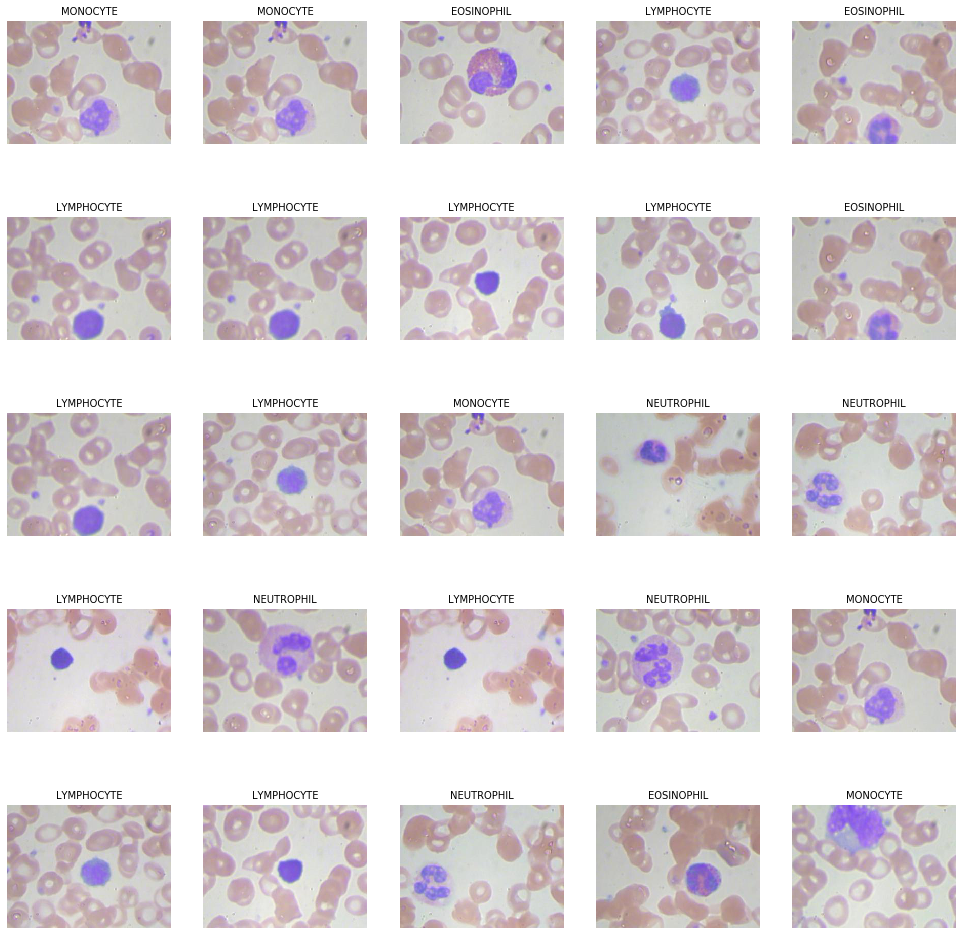

In [13]:
# Check the Training set
# Show some images from the training set
set_to_show = test_path 
#valid_path #test_path #train_path

W_grid = 5
L_grid = 5

fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))

axes = axes.ravel()

n_training = len(image_files)

for i in np.arange(0, W_grid*L_grid):
    
    folder_name = np.random.choice(glob(set_to_show + '/*'))
    pic = random_image = np.random.choice(glob(folder_name + '/*.jp*g'))
    axes[i].imshow(image.load_img(pic))
    axes[i].set_title(folder_name.rsplit('/')[1], fontsize=10)
    axes[i].set_frame_on(True)
    axes[i].axis('off')
    
plt.subplots_adjust(hspace=0.4)

# Model Creation

In [0]:
IMAGE_SIZE = [200, 200]

## Combination of Resnet and Inception blocks

The next section combines architecture from ResNet and Incetption. The architecture applies several Convolutional, Pooling and Batchnorm Layers. Furthermore, several One-To-One convolutions are applied as well. The result could be used as a refference to other model architectures to tackle the Blood Cells Problem


In [0]:
# Combination of Resnet and Inception blocks

i = Input(shape=IMAGE_SIZE + [3])
X = Conv2D(32, kernel_size=(3, 3), strides=(1, 1), activation='relu') (i)
X = BatchNormalization() (X)
X = Conv2D(64, kernel_size=(3, 3), strides=(1, 1), activation='relu') (X)
X = Conv2D(64, kernel_size=(3, 3), strides=(1, 1), activation='relu') (X)
# The output sofar should be 194x194x64


# Inception Block 1
X_3x3 = Conv2D(96, (1, 1), name='inception_3a_3x3_conv1') (X)
X_3x3 = BatchNormalization(epsilon=0.00001, name = 'inception_3a_3x3_bn1')(X_3x3)
X_3x3 = Activation('relu')(X_3x3)
X_3x3 = ZeroPadding2D(padding=(1, 1))(X_3x3)
X_3x3 = Conv2D(128, (3, 3), name='inception_3a_3x3_conv2')(X_3x3)
X_3x3 = BatchNormalization(epsilon=0.00001, name='inception_3a_3x3_bn2')(X_3x3)
X_3x3 = Activation('relu')(X_3x3)
# Output is (None, 194, 194, 128)

X_5x5 = Conv2D(16, (1, 1), name='inception_3a_5x5_conv1')(X)
X_5x5 = BatchNormalization(epsilon=0.00001, name='inception_3a_5x5_bn1')(X_5x5)
X_5x5 = Activation('relu')(X_5x5)
X_5x5 = ZeroPadding2D(padding=(2, 2))(X_5x5)
X_5x5 = Conv2D(32, (5, 5), name='inception_3a_5x5_conv2')(X_5x5)
X_5x5 = BatchNormalization(epsilon=0.00001, name='inception_3a_5x5_bn2')(X_5x5)
X_5x5 = Activation('relu')(X_5x5)
# Output is (None, 32, 198, 198)

# CONCAT
X = concatenate([X_3x3, X_5x5])

# Output is (None, 194, 194, 128)


# Resnet Block
X_shortcut = X
X = Conv2D(256, kernel_size=(1, 1), strides=(1, 1), padding='valid', activation='relu', name='one-by-one') (X)
X = MaxPooling2D(pool_size=(2,2), padding='valid') (X)
X = BatchNormalization()(X)
X = Conv2D(512, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='valid') (X)
X = Conv2D(512, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='valid') (X)
X = BatchNormalization()(X)
X = MaxPooling2D(pool_size=(2,2), padding='valid') (X)
X = Conv2D(1024, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='valid') (X)
X = Conv2D(1024, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='valid') (X)
X = MaxPooling2D(pool_size=(2,2), padding='valid') (X)

X = Flatten() (X)
x = Dense(500, activation ='relu')(X)
X = Dense(300, activation ='relu')(X)
X = Dense(K, activation='softmax') (X)

model = Model(i, X)

In [0]:
opt = tf.keras.optimizers.Adam()
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 198, 198, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 198, 198, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 196, 196, 64) 18496       batch_normalization[0][0]        
______________________________________________________________________________________________

In [0]:
# Create an instance of ImageDataGenerator
train_gen = ImageDataGenerator(
  rescale=1./255,
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
)

batch_size=32

test_gen = ImageDataGenerator(
  rescale=1./255
)

In [19]:
train_generator = train_gen.flow_from_directory(train_path, target_size=IMAGE_SIZE, 
                                          class_mode='categorical',
                                          batch_size=batch_size,
                                          shuffle=True)

valid_generator = test_gen.flow_from_directory(valid_path, target_size=IMAGE_SIZE,
                                          class_mode = 'categorical',
                                          batch_size=batch_size)

test_genetrator = test_gen.flow_from_directory(test_path, target_size=IMAGE_SIZE,
                                          class_mode='categorical',
                                          batch_size=1)

Found 9957 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.
Found 71 images belonging to 4 classes.


In [20]:
# Hold the labels into a list
labels = [None]*len(train_generator.class_indices)
for k, v in train_generator.class_indices.items():
  labels[v] = k
labels

['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']

### Add Callbacks

In [0]:
# Early Stopping with patience
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
# Save the best model
mc = ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/Blood_Cells/best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
callbacks = [es, mc]

### Fit the model

In [22]:
len(valid_image_files) // batch_size

77

In [23]:
import time 
start_time = time.time()
r = model.fit_generator(
    train_generator,
    validation_data = valid_generator,
    epochs = 2,
    steps_per_epoch= len(image_files) // batch_size,
    # validation_steps = len(valid_image_files) // batch_size,
    callbacks=callbacks
)

end_time = time.time()

# Save the model
model.save('/content/drive/My Drive/Colab Notebooks/Blood_Cells/Blood_v4.h5')
# Save the history file
history = pd.DataFrame(r.history)
history.to_csv(history.to_csv('/content/drive/My Drive/Colab Notebooks/Blood_Cells/history_Blood_v4.csv', index=False))

# Print elapsed time
time_elapsed = end_time - start_time
print(time_elapsed)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 311 steps, validate for 78 steps
Epoch 1/2
310/311 [============================>.] - ETA: 2s - loss: 6.7838 - accuracy: 0.2509
Epoch 00001: val_accuracy improved from -inf to 0.25050, saving model to /content/drive/My Drive/Colab Notebooks/Blood_Cells/best_model.h5
311/311 [==============================] - 697s 2s/step - loss: 6.7665 - accuracy: 0.2507 - val_loss: 1.3863 - val_accuracy: 0.2505
Epoch 2/2
310/311 [============================>.] - ETA: 1s - loss: 1.3864 - accuracy: 0.2463
Epoch 00002: val_accuracy did not improve from 0.25050
311/311 [==============================] - 624s 2s/step - loss: 1.3864 - accuracy: 0.2464 - val_loss: 1.3863 - val_accuracy: 0.2505
1320.8338494300842


Strangely, the result is similar to a random guess. I will find the bug in future work. I would like to try other partly pretrained models.

## Using ResNet model and pretrained weights to a certain layer

In [25]:
ptm = PretrainedModel(
    input_shape=IMAGE_SIZE + [3],
    weights='imagenet',
    include_top=False
)

ptm.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 206, 206, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 100, 100, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 100, 100, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [26]:
# Print the number of each layer - this is needed to know from which layer to train the weights
i = 0
for layer in ptm.layers:
    print(layer.name)
    print('Layer number' + str(i))
    print()
    i = i +1

input_2
Layer number0

conv1_pad
Layer number1

conv1_conv
Layer number2

conv1_bn
Layer number3

conv1_relu
Layer number4

pool1_pad
Layer number5

pool1_pool
Layer number6

conv2_block1_1_conv
Layer number7

conv2_block1_1_bn
Layer number8

conv2_block1_1_relu
Layer number9

conv2_block1_2_conv
Layer number10

conv2_block1_2_bn
Layer number11

conv2_block1_2_relu
Layer number12

conv2_block1_0_conv
Layer number13

conv2_block1_3_conv
Layer number14

conv2_block1_0_bn
Layer number15

conv2_block1_3_bn
Layer number16

conv2_block1_add
Layer number17

conv2_block1_out
Layer number18

conv2_block2_1_conv
Layer number19

conv2_block2_1_bn
Layer number20

conv2_block2_1_relu
Layer number21

conv2_block2_2_conv
Layer number22

conv2_block2_2_bn
Layer number23

conv2_block2_2_relu
Layer number24

conv2_block2_3_conv
Layer number25

conv2_block2_3_bn
Layer number26

conv2_block2_add
Layer number27

conv2_block2_out
Layer number28

conv2_block3_1_conv
Layer number29

conv2_block3_1_bn
Layer nu

In [27]:
# Train part of the model with our own data

# unfreeze pretrained model weights
ptm.trainable = True

# Tuning certain layers
fine_tune_at = 81
for layers in ptm.layers[:fine_tune_at]:
  layers.trainable = False
  print(layers.name)

input_2
conv1_pad
conv1_conv
conv1_bn
conv1_relu
pool1_pad
pool1_pool
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_2_bn
conv2_block1_2_relu
conv2_block1_0_conv
conv2_block1_3_conv
conv2_block1_0_bn
conv2_block1_3_bn
conv2_block1_add
conv2_block1_out
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_2_bn
conv2_block2_2_relu
conv2_block2_3_conv
conv2_block2_3_bn
conv2_block2_add
conv2_block2_out
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_2_bn
conv2_block3_2_relu
conv2_block3_3_conv
conv2_block3_3_bn
conv2_block3_add
conv2_block3_out
conv3_block1_1_conv
conv3_block1_1_bn
conv3_block1_1_relu
conv3_block1_2_conv
conv3_block1_2_bn
conv3_block1_2_relu
conv3_block1_0_conv
conv3_block1_3_conv
conv3_block1_0_bn
conv3_block1_3_bn
conv3_block1_add
conv3_block1_out
conv3_block2_1_conv
conv3_block2_1_bn
conv3_block2_1_relu
conv3_block2_2_conv
conv3_block2_2_bn
conv3_

In [28]:
# Add the fully connected ANN
K = len(folders)
x = Flatten()(ptm.output)
x = Dense(500, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(500, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(K, activation='softmax')(x)

model_RN = Model(inputs = ptm.input, outputs=x)

model_RN.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 206, 206, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 100, 100, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 100, 100, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [0]:
model_RN.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

init_weights = model_RN.get_weights()

In [0]:
# Create an instance of ImageDataGenerator
train_gen_resnet = ImageDataGenerator(
  preprocessing_function=preprocess_input,
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
)

test_gen_resnet = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

In [31]:
batch_size = 128

# create generators
train_generator = train_gen_resnet.flow_from_directory(
    train_path,
    target_size=IMAGE_SIZE,
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=True,
)

valid_generator = test_gen_resnet.flow_from_directory(
    valid_path,
    target_size=IMAGE_SIZE,
    class_mode="categorical",
    batch_size=batch_size,
)

test_generator = test_gen_resnet.flow_from_directory(
    test_path,
    target_size=IMAGE_SIZE,
    class_mode=None,
    batch_size=1,
)

Found 9957 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.
Found 71 images belonging to 4 classes.


In [32]:
import time 
start_time = time.time()
r_ResNet = model_RN.fit_generator(
    train_generator,
    validation_data = valid_generator,
    epochs = 15,
    steps_per_epoch=int(np.ceil(len(image_files) / batch_size)),
    validation_steps=int(np.ceil(len(valid_image_files) / batch_size)),
    callbacks=callbacks
)

end_time = time.time()

# Save the model
model_RN.save('/content/drive/My Drive/Colab Notebooks/Blood_Cells/Blood_ResNet_v2.h5')
# Save the history file
history = pd.DataFrame(r_ResNet.history)
history.to_csv(history.to_csv('/content/drive/My Drive/Colab Notebooks/Blood_Cells/history_Blood_ResNet_v2.csv', index=False))

# Print elapsed time
time_elapsed = end_time - start_time
print(time_elapsed)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 78 steps, validate for 20 steps
Epoch 1/15
77/78 [============================>.] - ETA: 1s - loss: 0.4093 - accuracy: 0.8499
Epoch 00001: val_accuracy improved from 0.25050 to 0.25613, saving model to /content/drive/My Drive/Colab Notebooks/Blood_Cells/best_model.h5
78/78 [==============================] - 144s 2s/step - loss: 0.4067 - accuracy: 0.8507 - val_loss: 115.1698 - val_accuracy: 0.2561
Epoch 2/15
77/78 [============================>.] - ETA: 1s - loss: 0.0968 - accuracy: 0.9631
Epoch 00002: val_accuracy improved from 0.25613 to 0.48130, saving model to /content/drive/My Drive/Colab Notebooks/Blood_Cells/best_model.h5
78/78 [==============================] - 131s 2s/step - loss: 0.0959 - accuracy: 0.9635 - val_loss: 5.5983 - val_accuracy: 0.4813
Epoch 3/15
77/78 [============================>.] - ETA: 1s - loss: 0.0513 - accuracy: 0.9829
Epoch 00003: val_accuracy improved from 0.48130 to 0.72296, saving model to /con

In [0]:
best_model = load_model('/content/drive/My Drive/Colab Notebooks/Blood_Cells/best_model.h5')

In [34]:
evaluation = best_model.evaluate_generator(generator=valid_generator,
                         steps=int(np.ceil(len(valid_image_files) / batch_size)))
print(evaluation)
print(best_model.metrics_names)

Instructions for updating:
Please use Model.evaluate, which supports generators.
  ...
    to  
  ['...']
[1.2681999504566193, 0.7712103]
['loss', 'accuracy']


Generating confusion matrix 2487
Found 2487 images belonging to 4 classes.
50


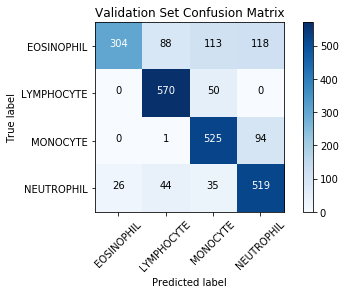

In [38]:
from sklearn.metrics import confusion_matrix
cm = get_confusion_matrix(valid_path, len(valid_image_files), test_gen_resnet, best_model)
plot_confusion_matrix(cm, labels, title='Validation Set Confusion Matrix')

Generating confusion matrix 71
Found 71 images belonging to 4 classes.


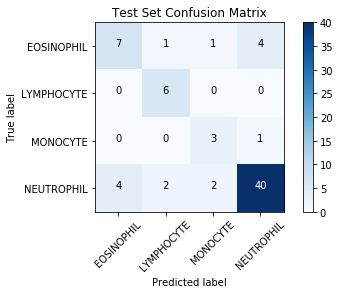

In [39]:
# Lets check the test set
cm = get_confusion_matrix(test_path, len(test_images), test_gen_resnet, best_model)
plot_confusion_matrix(cm, labels, title='Test Set Confusion Matrix')

## Using Inception model and pretrained weights to a certain layer

In [0]:
from tensorflow.keras.applications.inception_v3 import InceptionV3 as Inception, preprocess_input

In [78]:
ptm_incept = Inception(
    input_shape=IMAGE_SIZE + [3],
    weights='imagenet',
    include_top=False
)

ptm_incept.summary()

87916544/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 99, 99, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 99, 99, 32)   96          conv2d_7[0][0]                   
__________________________________________________________________________________________________
activation_4 (Activation)       (None, 99, 99, 32)   0           batch_normalization_5[0][0]      
______________________

In [0]:
# Print the number of each layer - this is needed to know from which layer to train the weights
i = 0
for layer in ptm_incept.layers:
    print(layer.name)
    print('Layer number' + str(i))
    print()
    i = i +1

input_36
Layer number0

conv2d_215
Layer number1

batch_normalization_142
Layer number2

activation_164
Layer number3

conv2d_216
Layer number4

batch_normalization_143
Layer number5

activation_165
Layer number6

conv2d_217
Layer number7

batch_normalization_144
Layer number8

activation_166
Layer number9

max_pooling2d_22
Layer number10

conv2d_218
Layer number11

batch_normalization_145
Layer number12

activation_167
Layer number13

conv2d_219
Layer number14

batch_normalization_146
Layer number15

activation_168
Layer number16

max_pooling2d_23
Layer number17

conv2d_223
Layer number18

batch_normalization_150
Layer number19

activation_172
Layer number20

conv2d_221
Layer number21

conv2d_224
Layer number22

batch_normalization_148
Layer number23

batch_normalization_151
Layer number24

activation_170
Layer number25

activation_173
Layer number26

average_pooling2d_9
Layer number27

conv2d_220
Layer number28

conv2d_222
Layer number29

conv2d_225
Layer number30

conv2d_226
Layer n

In [79]:
# Train part of the model with our own data
# Until 249 (excluded)

# unfreeze pretrained model weights
ptm_incept.trainable = True

# Tuning certain layers
fine_tune_at = 249
for layers in ptm_incept.layers[:fine_tune_at]:
  layers.trainable = False
  print(layers.name)

input_3
conv2d_7
batch_normalization_5
activation_4
conv2d_8
batch_normalization_6
activation_5
conv2d_9
batch_normalization_7
activation_6
max_pooling2d_3
conv2d_10
batch_normalization_8
activation_7
conv2d_11
batch_normalization_9
activation_8
max_pooling2d_4
conv2d_15
batch_normalization_13
activation_12
conv2d_13
conv2d_16
batch_normalization_11
batch_normalization_14
activation_10
activation_13
average_pooling2d
conv2d_12
conv2d_14
conv2d_17
conv2d_18
batch_normalization_10
batch_normalization_12
batch_normalization_15
batch_normalization_16
activation_9
activation_11
activation_14
activation_15
mixed0
conv2d_22
batch_normalization_20
activation_19
conv2d_20
conv2d_23
batch_normalization_18
batch_normalization_21
activation_17
activation_20
average_pooling2d_1
conv2d_19
conv2d_21
conv2d_24
conv2d_25
batch_normalization_17
batch_normalization_19
batch_normalization_22
batch_normalization_23
activation_16
activation_18
activation_21
activation_22
mixed1
conv2d_29
batch_normalization

In [80]:
# Add the fully connected ANN
K = len(folders)
x = Flatten()(ptm_incept.output)
x = Dense(500, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(500, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(K, activation='softmax')(x)

model_inception = Model(inputs = ptm_incept.input, outputs=x)

model_inception.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 99, 99, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 99, 99, 32)   96          conv2d_7[0][0]                   
__________________________________________________________________________________________________
activation_4 (Activation)       (None, 99, 99, 32)   0           batch_normalization_5[0][0]      
____________________________________________________________________________________________

In [0]:
model_inception.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

init_weights_inception = model_inception.get_weights()

In [0]:
# Create an instance of ImageDataGenerator
train_gen_incept = ImageDataGenerator(
  preprocessing_function=preprocess_input,
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
)

test_gen_incept = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

In [83]:
batch_size = 128

# create generators
train_generator = train_gen_incept.flow_from_directory(
    train_path,
    target_size=IMAGE_SIZE,
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=True,
)

valid_generator = test_gen_incept.flow_from_directory(
    valid_path,
    target_size=IMAGE_SIZE,
    class_mode="categorical",
    batch_size=batch_size,
)

test_generator = test_gen_incept.flow_from_directory(
    test_path,
    target_size=IMAGE_SIZE,
    class_mode=None,
    batch_size=1,
)

Found 9957 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.
Found 71 images belonging to 4 classes.


In [85]:
import time 
start_time = time.time()
r_Inception = model_inception.fit_generator(
    train_generator,
    validation_data = valid_generator,
    epochs = 3,
    steps_per_epoch=int(np.ceil(len(image_files) / batch_size)),
    validation_steps=int(np.ceil(len(valid_image_files) / batch_size)),
    callbacks=callbacks
)

end_time = time.time()

# Save the model
model_inception.save('/content/drive/My Drive/Colab Notebooks/Blood_Cells/Blood_Incept_v1.h5')
# Save the history file
history = pd.DataFrame(r_Inception.history)
history.to_csv(history.to_csv('/content/drive/My Drive/Colab Notebooks/Blood_Cells/history_Blood_Incept_v1.csv', index=False))

# Print elapsed time
time_elapsed = end_time - start_time
print(time_elapsed)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 78 steps, validate for 20 steps
Epoch 1/3
77/78 [============================>.] - ETA: 1s - loss: 0.1709 - accuracy: 0.9388
Epoch 00001: val_accuracy did not improve from 0.81423
78/78 [==============================] - 106s 1s/step - loss: 0.1703 - accuracy: 0.9390 - val_loss: 3.3646 - val_accuracy: 0.3008
Epoch 2/3
77/78 [============================>.] - ETA: 1s - loss: 0.1371 - accuracy: 0.9514
Epoch 00002: val_accuracy did not improve from 0.81423
78/78 [==============================] - 108s 1s/step - loss: 0.1366 - accuracy: 0.9516 - val_loss: 4.7469 - val_accuracy: 0.2815
Epoch 3/3
77/78 [============================>.] - ETA: 1s - loss: 0.1232 - accuracy: 0.9583
Epoch 00003: val_accuracy did not improve from 0.81423
78/78 [==============================] - 106s 1s/step - loss: 0.1227 - accuracy: 0.9584 - val_loss: 5.6301 - val_accuracy: 0.2654
322.0244069099426


In [0]:
# The result of the Inception is actually obtained after 5 epochs

# Results

In this notebook I compared the model results of ResNet, Inception, and a self-constructed architecture composed of ResNet and Inception blocks. The models were applied to the Blood_cells dataset at Kaggle
https://www.kaggle.com/paultimothymooney/blood-cells

The training was with just a few epochs and early stopping with 4 epochs.

With this dataset and this training conditions ResNet showed much better performance than the other two models.

The ResNet model with pretrained weights upto layer 81 from 175 achieved 77% on the validation set. However the result shows a prety high variance. Therefore, techniques need to be applied to reduce overfitting of the model such as additional DropOut Layers.

#### UTILS

In [0]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  # if normalize:
  #     cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  #     print("Normalized confusion matrix")
  # else:
  #     print('Confusion matrix, without normalization')

  # print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

In [0]:
def get_confusion_matrix(data_path, N, image_generator, model):
  # we need to see the data in the same order
  # for both predictions and targets
  print("Generating confusion matrix", N)
  predictions = []
  targets = []
  i = 0
  for x, y in image_generator.flow_from_directory(data_path, target_size=IMAGE_SIZE, shuffle=False):
    i += 1
    if i % 50 == 0:
      print(i)
    p = model.predict(x)
    p = np.argmax(p, axis=1)
    y = np.argmax(y, axis=1)
    predictions = np.concatenate((predictions, p))
    targets = np.concatenate((targets, y))
    if len(targets) >= N:
      break

  cm = confusion_matrix(targets, predictions)
  return cm